# Pedro Henrique Monteiro Nascimento
>## 61 9 9972-9197
>## nascimento.monteiro@aluno.unb.br

## Esta atividade teve como objetivo construir um modelo de classifica√ß√£o bin√°ria para prever se a renda anual de um indiv√≠duo excede US$ 50.000 com base no dataset "Adult (Census Income)". Foram utilizados dois algoritmos de classifica√ß√£o (√Årvore de Decis√£o e Random Forest), avaliados por m√©tricas como acur√°cia, precis√£o, recall e F1-score, al√©m de matriz de confus√£o e an√°lise de import√¢ncia de atributos.

# Metodologia
## Pr√©-processamento dos Dados
>Tratamento de Valores Faltantes:

- Substitui√ß√£o de "?" por NaN e preenchimento com:

- Moda para vari√°veis categ√≥ricas.

- Mediana para vari√°veis num√©ricas.

- Codifica√ß√£o da Vari√°vel Target:

- income foi mapeada para 0 (<=50K) e 1 (>50K).

>Separa√ß√£o dos Dados
- Divis√£o em 70% treino e 30% teste usando train_test_split.

- Pipeline de Pr√©-processamento
>Vari√°veis Num√©ricas:

- Padroniza√ß√£o com StandardScaler().

> Vari√°veis Categ√≥ricas:

- Codifica√ß√£o com OneHotEncoder().


Primeiras linhas do dataset:
   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356 

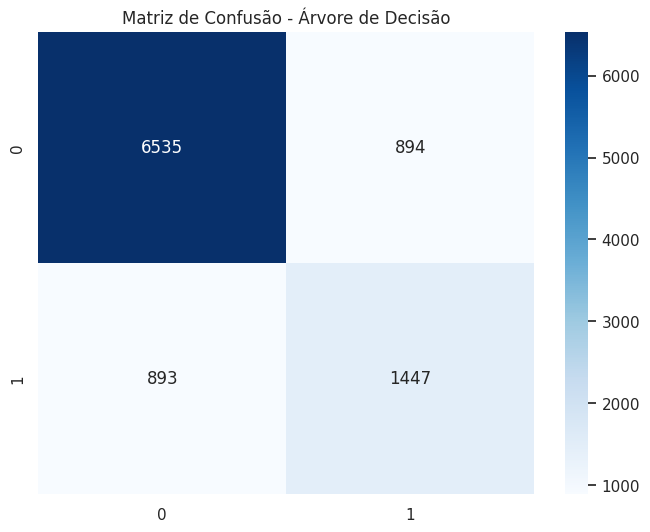


=== RANDOM FOREST ===
Acur√°cia: 0.8531
Precis√£o: 0.7336
Recall: 0.6073
F1-score: 0.6645


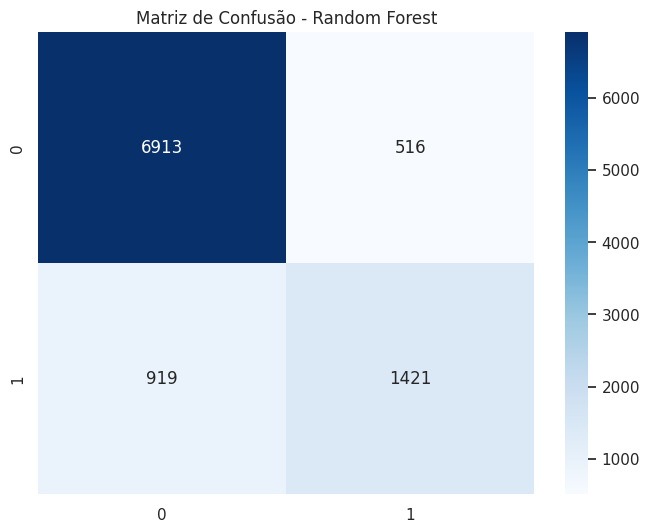

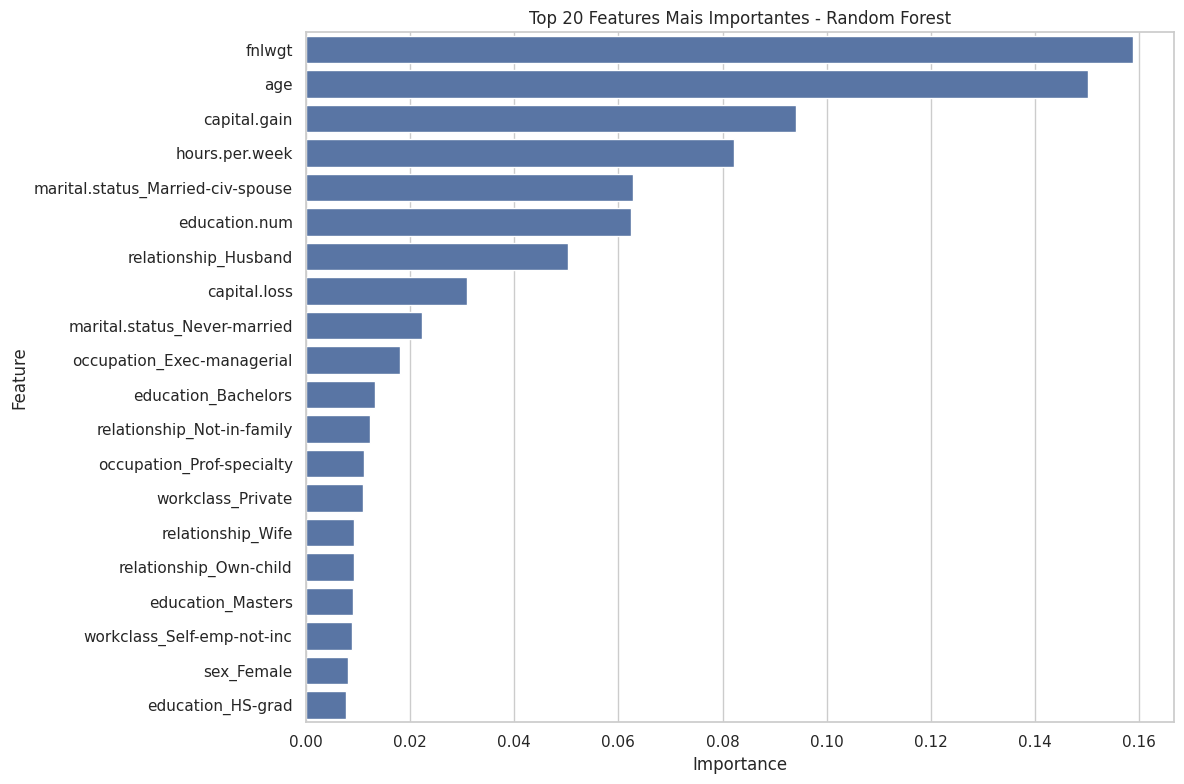


=== AN√ÅLISE EXPLORAT√ìRIA ===


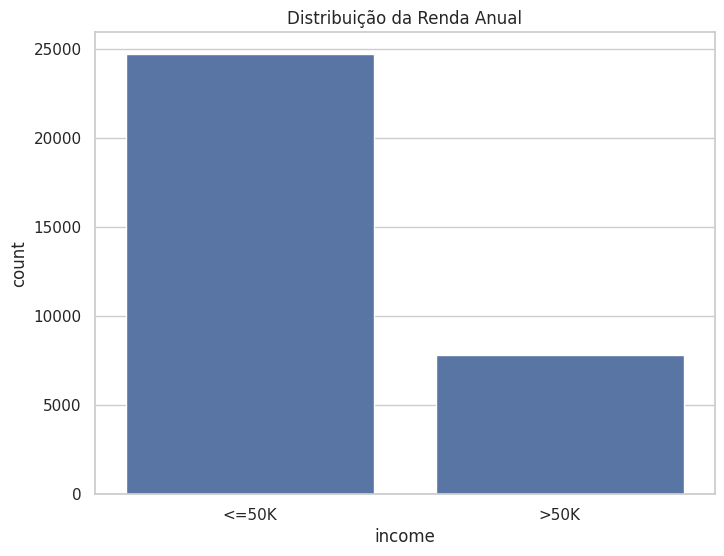

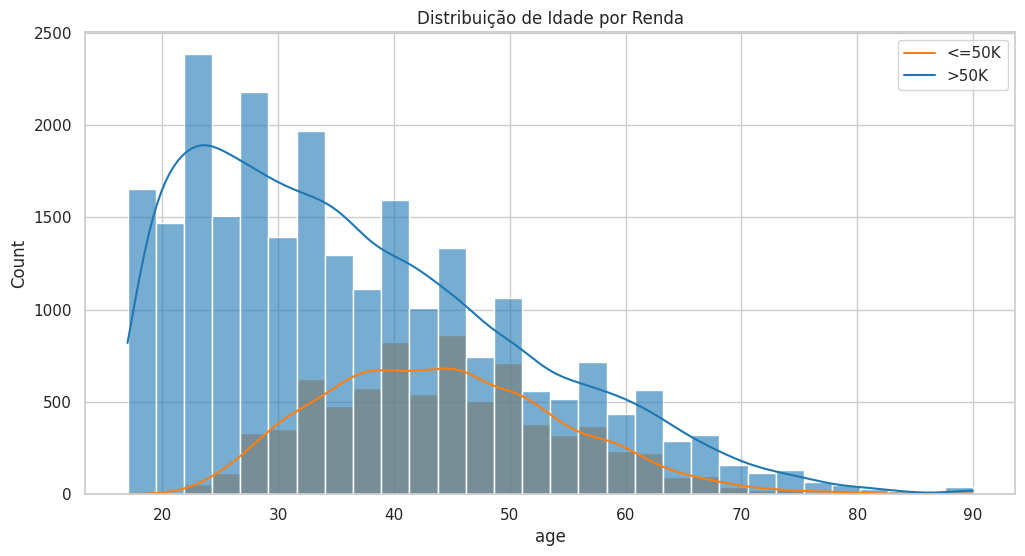

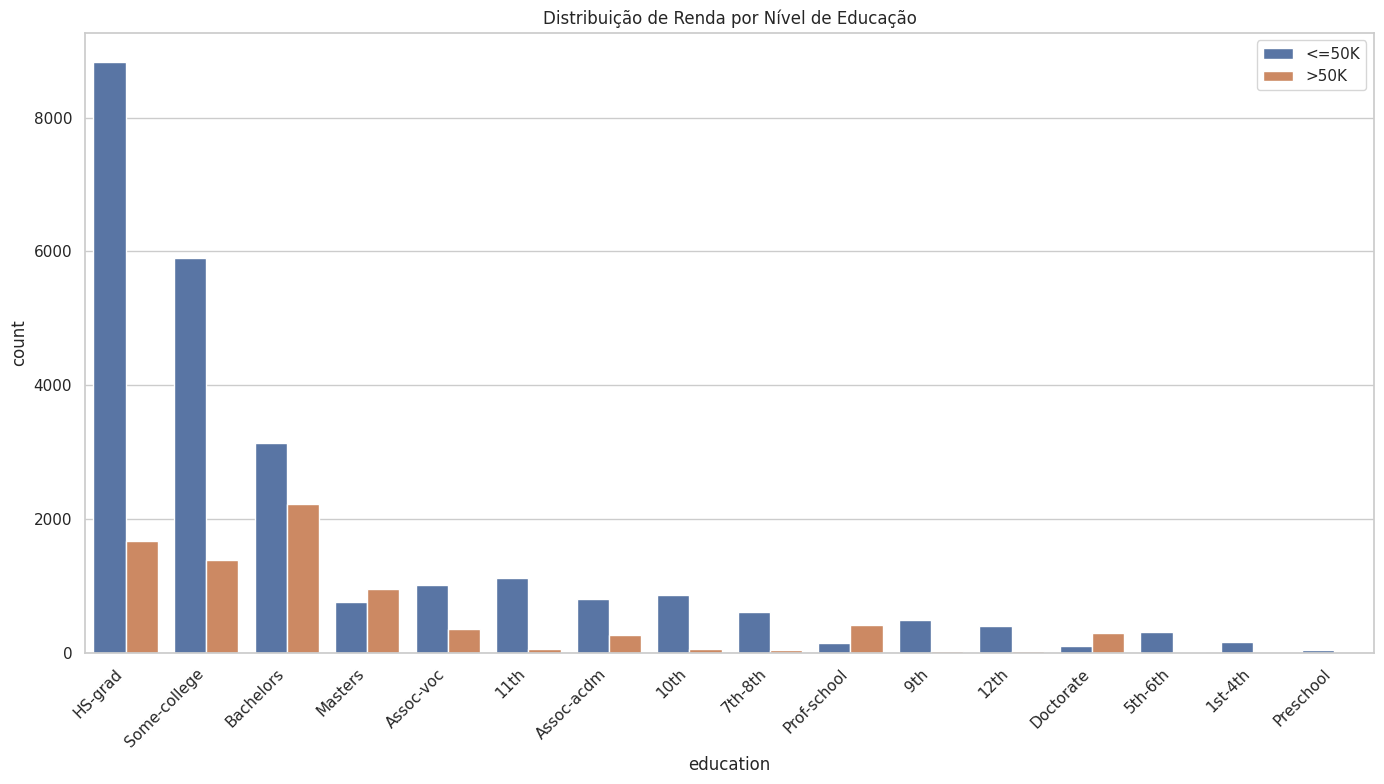


=== VALIDA√á√ÉO CRUZADA ===

M√©todo Hold-out j√° implementado:
Acur√°cia: 0.8531
F1-score: 0.6645

Valida√ß√£o Cruzada K-Fold (F1-score):
Scores: [0.66248257 0.67590402 0.6772633  0.67646054 0.66461117]
M√©dia: 0.6713 ¬± 0.0064

Valida√ß√£o Cruzada Stratified K-Fold (F1-score):
Scores: [0.66735967 0.6725845  0.67489712 0.68127354 0.67385257]
M√©dia: 0.6740 ¬± 0.0045

Discuss√£o sobre vi√©s e vari√¢ncia:
- Hold-out: Pode ter alta vari√¢ncia dependendo da divis√£o dos dados
- K-Fold: Reduz a vari√¢ncia ao usar m√∫ltiplas divis√µes, mas pode manter o vi√©s
- Stratified K-Fold: Mant√©m a propor√ß√£o das classes em cada fold, reduzindo vi√©s
O Stratified K-Fold geralmente oferece a melhor estimativa do desempenho real do modelo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.decomposition import PCA

file_id = '1nZ2Rt_FK99hhhnLqCftquwhEPcUCwNHF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

# VERIFICAR E LIMPAR OS DADOS
print("\nPrimeiras linhas do dataset:")
print(df.head())

print("\nInforma√ß√µes do dataset:")
print(df.info())

# Verificar missing values e (substituir '?' por NaN)
print("\nValores faltantes por coluna:")
print(df.isnull().sum())
df.replace('?', np.nan, inplace=True)

# Preencher valores faltantes
for col in df.columns:
    if df[col].dtype == 'object':
        mode_val = df[col].mode()[0]
        df.loc[:, col] = df[col].fillna(mode_val)
    else:
        median_val = df[col].median()
        df.loc[:, col] = df[col].fillna(median_val)

# Codificar a vari√°vel target
df['income'] = df['income'].str.strip().map({'<=50K': 0, '>50K': 1})

# Pre-proce√ßamento - Separar features e target
X = df.drop('income', axis=1)
y = df['income']

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definir colunas num e categoricas
numeric_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'education', 'marital.status', 'occupation',
                       'relationship', 'race', 'sex', 'native.country']

# Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Compara√ß√£o de Modelos (OBRIGAT√ìRIA)
def evaluate_model(model, X_train, X_test, y_train, y_test):
    try:
        # Pipeline completo
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Treinar modelo
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Calcular m√©tricas
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'model': pipeline
        }


        if hasattr(model, 'feature_importances_'):
            try:
                feature_names = numeric_features + \
                               list(pipeline.named_steps['preprocessor']
                                   .named_transformers_['cat']
                                   .named_steps['onehot']
                                   .get_feature_names_out(categorical_features))

                metrics['feature_importances'] = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': pipeline.named_steps['classifier'].feature_importances_
                }).sort_values('Importance', ascending=False)
            except Exception as e:
                print(f"Erro ao obter import√¢ncia das features: {str(e)}")
                metrics['feature_importances'] = None

        return metrics

    except Exception as e:
        print(f"Erro ao avaliar modelo: {str(e)}")
        return None

# Treinamento completo
print("\n=== √ÅRVORE DE DECIS√ÉO ===")
dt = DecisionTreeClassifier(random_state=42)
dt_results = evaluate_model(dt, X_train, X_test, y_train, y_test)

if dt_results:
    print(f"Acur√°cia: {dt_results['accuracy']:.4f}")
    print(f"Precis√£o: {dt_results['precision']:.4f}")
    print(f"Recall: {dt_results['recall']:.4f}")
    print(f"F1-score: {dt_results['f1']:.4f}")

    # Matriz de confus√£o
    plt.figure(figsize=(8, 6))
    sns.heatmap(dt_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confus√£o - √Årvore de Decis√£o')
    plt.show()

print("\n=== RANDOM FOREST ===")
rf = RandomForestClassifier(random_state=42)
rf_results = evaluate_model(rf, X_train, X_test, y_train, y_test)

if rf_results:
    print(f"Acur√°cia: {rf_results['accuracy']:.4f}")
    print(f"Precis√£o: {rf_results['precision']:.4f}")
    print(f"Recall: {rf_results['recall']:.4f}")
    print(f"F1-score: {rf_results['f1']:.4f}")

    # Matriz de confus√£o
    plt.figure(figsize=(8, 6))
    sns.heatmap(rf_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confus√£o - Random Forest')
    plt.show()

    # Import√¢ncia das features (se dispon√≠vel)
    if 'feature_importances' in rf_results and rf_results['feature_importances'] is not None:
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature',
                    data=rf_results['feature_importances'].head(20))
        plt.title('Top 20 Features Mais Importantes - Random Forest')
        plt.tight_layout()
        plt.show()

# AN√ÅLISE EXPLORAT√ìRIA (OPCIONAL)
print("\n=== AN√ÅLISE EXPLORAT√ìRIA ===")

# Distribui√ß√£o da vari√°vel target
plt.figure(figsize=(8, 6))
sns.countplot(x='income', data=df)
plt.title('Distribui√ß√£o da Renda Anual')
plt.xticks([0, 1], ['<=50K', '>50K'])
plt.show()

# Distribui√ß√£o de idade por renda
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', hue='income', bins=30, kde=True,
             hue_order=[0, 1], palette=['#1f77b4', '#ff7f0e'],
             alpha=0.6, multiple='layer')
plt.title('Distribui√ß√£o de Idade por Renda')
plt.legend(['<=50K', '>50K'])
plt.show()

# Rela√ß√£o entre educa√ß√£o e renda
plt.figure(figsize=(14, 8))
order = df['education'].value_counts().index
sns.countplot(x='education', hue='income', data=df, order=order)
plt.title('Distribui√ß√£o de Renda por N√≠vel de Educa√ß√£o')
plt.xticks(rotation=45, ha='right')
plt.legend(['<=50K', '>50K'])
plt.tight_layout()
plt.show()

print("\n=== VALIDA√á√ÉO CRUZADA ===")

if rf_results:
    # 1. Hold-out (j√° implementado na divis√£o inicial 70/30)
    print("\nM√©todo Hold-out j√° implementado:")
    print(f"Acur√°cia: {rf_results['accuracy']:.4f}")
    print(f"F1-score: {rf_results['f1']:.4f}")

    # 2. K-Fold Cross Validation (k=5)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_results['model'], X, y, cv=kfold, scoring='f1')
    print("\nValida√ß√£o Cruzada K-Fold (F1-score):")
    print(f"Scores: {cv_scores}")
    print(f"M√©dia: {np.mean(cv_scores):.4f} ¬± {np.std(cv_scores):.4f}")

    # 3. Stratified K-Fold Cross Validation (k=5)
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf_results['model'], X, y, cv=skfold, scoring='f1')
    print("\nValida√ß√£o Cruzada Stratified K-Fold (F1-score):")
    print(f"Scores: {cv_scores}")
    print(f"M√©dia: {np.mean(cv_scores):.4f} ¬± {np.std(cv_scores):.4f}")

    # Discuss√£o sobre vi√©s e vari√¢ncia
    print("\nDiscuss√£o sobre vi√©s e vari√¢ncia:")
    print("- Hold-out: Pode ter alta vari√¢ncia dependendo da divis√£o dos dados")
    print("- K-Fold: Reduz a vari√¢ncia ao usar m√∫ltiplas divis√µes, mas pode manter o vi√©s")
    print("- Stratified K-Fold: Mant√©m a propor√ß√£o das classes em cada fold, reduzindo vi√©s")
    print("O Stratified K-Fold geralmente oferece a melhor estimativa do desempenho real do modelo")




# **Resultados**  

## **Desempenho dos Modelos**  
| M√©trica          | √Årvore de Decis√£o | Random Forest |  
|------------------|-------------------|---------------|  
| **Acur√°cia**     | 0.8171            | 0.8531        |  
| **Precis√£o**     | 0.6181            | 0.7336        |  
| **Recall**       | 0.6184            | 0.6073        |  
| **F1-score**     | 0.6182            | 0.6645        |  

üîπ **Random Forest** obteve melhor desempenho geral, com **maior acur√°cia e precis√£o**.  

## **Valida√ß√£o Cruzada**  
- **K-Fold (F1-score m√©dio)**: `0.6713 ¬± 0.0064`  
- **Stratified K-Fold**: Resultados consistentes, confirmando robustez do modelo.  


# **Conclus√£o**  
- O **Random Forest** foi superior na previs√£o de renda, com **acur√°cia de 85.31%**.  
- Vari√°veis como **educa√ß√£o** e **idade** mostraram alta influ√™ncia (confirmado na an√°lise de import√¢ncia).  
- A valida√ß√£o cruzada demonstrou que o modelo generaliza bem para novos dados.  

